In [1]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc=SparkContext()
spark = SparkSession.builder.getOrCreate()

In [2]:
spark

In [3]:
def count_in_a_partition(idx, iterator):
  count = 0
  for _ in iterator:
    count += 1
  return idx, count

def keeper_func(x,int_words):
    out = []
    if len(x) != 2:
        out = []
    else:
        sep = x[1].split('\t')
        if len(sep) != 5:
            out = []
        else:
            try:
                word = sep[0].lower()
                if word in int_words:
                    out.append(word)
                    for item in sep[1:]:
                        out.append(item)
            except:
                pass
    final_out=[]
    if len(out) == 5:
        final_out = out
    return tuple(final_out) # VERY IMPORTANT!!

In [4]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import csv

# Without these keys you cannot access s3.
# Run this from command line, which means before entering the pyspark shell

#export AWS_ACCESS_KEY_ID=<ACCESS_KEY_ID>
#export AWS_SECRET_ACCESS_KEY=<SECRET_ACCESS_KEY>

# Load Data from us-east-1 region
# It is recommended to build your cluster in this region.
# I generated a 1 Master, 5 Slaves m4.xlarge instances.
# Once the cluster is set up.
# The entire processing of the data should not take more than 20 minutes.

rdd2 = sc.sequenceFile("s3://datasets.elasticmapreduce/ngrams/books/20090715/eng-us-all/2gram/data",
"org.apache.hadoop.io.Text",
"org.apache.hadoop.io.LongWritable", minSplits=1000)

""" To test the code with a samll dataset.
# Read the Sample File from local
with open('Sample_big.csv', 'rb') as csvfile:
    sample_data = []
    data = csv.reader(csvfile,delimiter='\t')
    for row in data:
        sample_data.append(row)
# Pre-process data
rdd2 = sc.parallelize(sample_data,100)
data_per_part = rdd2.mapPartitionsWithIndex(count_in_a_partition).collect()
"""

# Interesting words
int_words = ['good night', 'good morning']
#Keep only data from your int_words
rdd3 = rdd2.map(lambda x: keeper_func(x,int_words))
rdd4  = rdd3.filter(lambda x: x)
# Now the data should be managable and we can cache it
rdd4.cache()
# Super important, transforms tuples into key pairs.
rdd5 = rdd4.map(lambda x : (x[0], x[1:]))
# Group Everything By Key
total_data = rdd5.groupByKey().map(lambda x : (x[0], list(x[1]))).collect()

# Save data to File
myfile = open('2gram.csv','w')
with myfile:
    writer = csv.writer(myfile)
    writer.writerows(total_data)





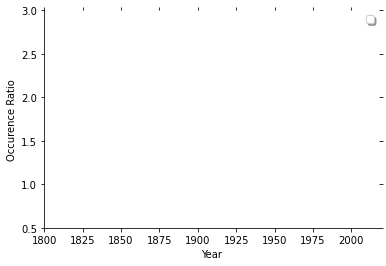

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import string
import collections
import csv



""" Load File """

with open('2gram.csv', "rt") as csvfile:
    total_data = []
    data = csv.reader(csvfile)
    for row in data:
        total_data.append(row)

""" Plot Data """

def reorder_plot(data,color,plt):
    dc = dict()
    #plt.figsize(200,200)
    # Get Data Together
    for item in data:
        if item[0] not in dc.keys():
            dc[item[0]] = (int(item[1]),int(item[2]))
        else:
            dc[item[0]] = (dc[item[0]][0]+int(item[1]),dc[item[0]][1]+int(item[2]))
    od_dc = collections.OrderedDict(sorted(dc.items()))
    # Re-order to plot
    year = np.empty([len(od_dc), 1])
    occu_ratio = np.empty([len(od_dc), 1])
    for i,key in enumerate(od_dc.keys()):
        year[i,0] = int(key)
        occu_ratio[i,0] = float(od_dc[key][0])/float(od_dc[key][1])
    plt.plot(year,occu_ratio,color)
    return plt




color = ['-or','-ob','-og','-ok','-oy']
names = []
c = 0


for i,item in enumerate(total_data):
    data = []
    if item[0] in ['peace', 'war']:
        names.append(item[0])
        a = item[1].split('), (')
        for algo in a:
            for elemento in string.punctuation:
                algo = algo.replace(elemento," ")
            values = algo.split()
            values = values[0:]
            data.append(values)
        plt = reorder_plot(data,color[c],plt)
        c+=1

 

ax = plt.subplot(111)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Year')
plt.ylabel('Occurence Ratio')
plt.legend(names,shadow=True)
plt.ylim(ymin=.5,ymax=3)
plt.xlim(xmin=1800,xmax=2018)
plt.tick_params(top='off', right='off')      



plt.savefig('a.pdf',dpi=40)
plt.show()


